In [1]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import umap
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from collections import Counter
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Could not save font_manager cache [Errno 13] Permission denied: 'C:\\Users\\91720\\.matplotlib\\fontlist-v390.json.matplotlib-lock'
d:\QCNN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import numpy as np

labels_df = pd.read_csv("D:\QCNN\experiment-ii_labels.csv")
base_dir = "D:\QCNN\experiment-ii"

file_paths, unique_labels = [], []
X=[]
for _, row in labels_df.iterrows():
    subject = row["Subject"].strip()
    mat_type = row["Mat_Type"].strip()
    file_name = row["File_Name"].strip()
    label = row["Label"].strip()

    full_path = os.path.normpath(os.path.join(base_dir, subject, mat_type, file_name))

    if os.path.exists(full_path):
        file_paths.append(full_path)
        unique_labels.append(label)
    else:
        print("❌ Missing file:", os.path.abspath(full_path))

    for path in file_paths:
        try:
            matrix = np.loadtxt(path)  # Assumes whitespace- or tab-delimited .txt files
            X.append(matrix.flatten())  # Flatten 2D matrix to 1D
        except Exception as e:
            print(f"Failed to load {path}: {e}")

label_mapping = {label: idx for idx, label in enumerate(sorted(set(unique_labels)))}
labels = [label_mapping[lbl] for lbl in unique_labels]

print("\n✅ Label Mapping:", label_mapping)
print("✅ Encoded Labels:", labels[:10])

X = np.array(X)
Y = np.array(labels)



✅ Label Mapping: {'Left': 0, 'Right': 1, 'Supine': 2}
✅ Encoded Labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

# Sample check
if len(X) == 0:
    raise ValueError("Input data X is empty. Cannot fit the scaler.")

# Convert to 2D numpy array
X = np.array(X)
if X.ndim == 1:
    X = X.reshape(-1, 1)  # Ensures it's 2D

# Now fit and save
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

os.makedirs("preprocess", exist_ok=True)
joblib.dump(scaler, 'scaler3.pkl')
print("Scaler saved to scaler3.pkl")


Scaler saved to scaler3.pkl


In [4]:
# 2. Autoencoder for initial dimensionality reduction
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

    def encode(self, x):
        return self.encoder(x)

input_dim = X_scaled.shape[1]
bottleneck_dim = 50
autoencoder = AutoEncoder(input_dim, bottleneck_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

NameError: name 'X_scaled' is not defined

In [ ]:
# Train Autoencoder
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
for epoch in range(100):
    optimizer.zero_grad()
    output = autoencoder(X_tensor)
    loss = criterion(output, X_tensor)
    loss.backward()
    optimizer.step()

X_encoded = autoencoder.encode(X_tensor).detach().numpy()

In [ ]:
# 3. UMAP for further dimensionality reduction (to match qubit count)
n_qubits = 11
umap_model = umap.UMAP(n_components=n_qubits, random_state=42)
X_umap = umap_model.fit_transform(X_encoded)

import joblib
joblib.dump(umap_model, "umap3_model.pkl")

d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\QCNN\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


['umap3_model.pkl']

In [18]:
# 4. Handle class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_umap, Y)

# Print class distribution after SMOTE
label_counts = Counter(y_resampled)
print("Class distribution after SMOTE:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Class distribution after SMOTE:
Label 2: 271 samples
Label 1: 271 samples
Label 0: 271 samples


In [12]:
# 5. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

NameError: name 'X_resampled' is not defined

In [25]:
# 6. PennyLane Quantum Circuit 
num_qubits=11
num_layers=6
dev = qml.device("default.qubit", wires=n_qubits)

In [3]:
def QuantumConvLayer(inputs, weights):
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev, interface="torch")
    def circuit(x, w):
        qml.AngleEmbedding(x, wires=range(num_qubits), rotation='Y')

        for l in range(num_layers):
            for i in range(num_qubits):
                qml.RY(w[l, i, 0], wires=i)
                qml.RZ(w[l, i, 1], wires=i)

            # Entanglement: First ring
            for i in range(num_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[num_qubits - 1, 0])  # close the ring

            # Optional: Add another layer for deeper entanglement
            for i in range(num_qubits):
                qml.CRX(w[l, i, 0], wires=[i, (i + 2) % num_qubits])

        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit(inputs, weights)


In [4]:
def QuantumPoolingLayer(inputs):
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev, interface="torch")
    def circuit(x):
        qml.AngleEmbedding(x, wires=range(num_qubits), rotation='Y')

        # Compress even+odd wires together
        for i in range(0, num_qubits - 1, 2):
            qml.CRY(np.pi / 2, wires=[i, i + 1])
            qml.CZ(wires=[i, i + 1])

        # Interference via H and S gates
        for i in range(num_qubits):
            qml.Hadamard(wires=i)
            qml.S(wires=i)

        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit(inputs)


In [6]:
class QCNN(nn.Module):
    def __init__(self, num_qubits, num_layers, num_classes):
        super(QCNN, self).__init__()
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.q_params = nn.Parameter(0.01 * torch.randn(num_layers, num_qubits, 2))

        # Fully Connected Layers with LayerNorm and Dropout
        self.fc1 = nn.Linear(num_qubits, 128)
        self.norm1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.norm2 = nn.LayerNorm(64)
        self.fc3 = nn.Linear(64, 32)
        self.norm3 = nn.LayerNorm(32)
        self.fc4 = nn.Linear(32, 16)
        self.out = nn.Linear(16, num_classes)

    def forward(self, x, return_quantum_features=False):
        x = x.view(x.shape[0], -1)
        quantum_outputs = []

        for sample in x:
            conv_out = QuantumConvLayer(sample, self.q_params)
            pool_out = QuantumPoolingLayer(torch.tensor(conv_out, dtype=torch.float32))
            quantum_outputs.append(torch.tensor(pool_out, dtype=torch.float32))

        x = torch.stack(quantum_outputs).to(x.device)

        if return_quantum_features:
            logits = self.out(self.fc4(self.fc3(self.fc2(self.fc1(x)))))
            return logits, x

        x = F.relu(self.norm1(self.fc1(x)))
        x = F.dropout(x, p=0.3)

        x = F.relu(self.norm2(self.fc2(x)))
        x = F.dropout(x, p=0.2)

        x = F.relu(self.norm3(self.fc3(x)))
        x = F.dropout(x, p=0.1)

        x = F.relu(self.fc4(x))
        return self.out(x)

In [7]:
# 6. Initialize
num_layers=6
num_qubits=11
num_classes=3
model = QCNN(num_qubits,num_layers,num_classes)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 1.0]))  # Update with true class weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = QCNN(num_qubits=11, num_layers=3, num_classes=4)

print("=== QCNN Architecture Summary ===")
print(model)
print("\nQuantum Parameters Shape:", model.q_params.shape)

print("\n=== Named Parameters ===")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


=== QCNN Architecture Summary ===
QCNN(
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
)

Quantum Parameters Shape: torch.Size([3, 11, 2])

=== Named Parameters ===
q_params: torch.Size([3, 11, 2])
fc1.weight: torch.Size([128, 11])
fc1.bias: torch.Size([128])
norm1.weight: torch.Size([128])
norm1.bias: torch.Size([128])
fc2.weight: torch.Size([64, 128])
fc2.bias: torch.Size([64])
norm2.weight: torch.Size([64])
norm2.bias: torch.Size([64])
fc3.weight: torch.Size([32, 64])
fc3.bias: torch.Size([32])
norm3.weight: torch.Size([32])
norm3.bias: torch.S

In [11]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)



NameError: name 'X_train' is not defined

In [30]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
# Trackers
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

n_epochs = 30

for epoch in range(n_epochs):
    # ---------- TRAINING ----------
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # ---------- LOG ----------
    print(f"Epoch [{epoch+1}/{n_epochs}]")
    print(f"  Train    -> Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%")
    print(f"  Validate -> Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%\n")


Epoch [1/30]
  Train    -> Loss: 1.1014, Accuracy: 33.08%
  Validate -> Loss: 1.1023, Accuracy: 33.13%

Epoch [2/30]
  Train    -> Loss: 1.0964, Accuracy: 35.08%
  Validate -> Loss: 1.0715, Accuracy: 44.79%

Epoch [3/30]
  Train    -> Loss: 1.0743, Accuracy: 38.62%
  Validate -> Loss: 1.0503, Accuracy: 42.33%

Epoch [4/30]
  Train    -> Loss: 1.0404, Accuracy: 44.00%
  Validate -> Loss: 1.0159, Accuracy: 50.92%

Epoch [5/30]
  Train    -> Loss: 0.9529, Accuracy: 53.38%
  Validate -> Loss: 0.9219, Accuracy: 53.99%

Epoch [6/30]
  Train    -> Loss: 0.8969, Accuracy: 56.62%
  Validate -> Loss: 0.9355, Accuracy: 52.76%

Epoch [7/30]
  Train    -> Loss: 0.8672, Accuracy: 60.46%
  Validate -> Loss: 0.8907, Accuracy: 58.90%

Epoch [8/30]
  Train    -> Loss: 0.8230, Accuracy: 63.54%
  Validate -> Loss: 0.8397, Accuracy: 57.67%

Epoch [9/30]
  Train    -> Loss: 0.7924, Accuracy: 64.46%
  Validate -> Loss: 0.8115, Accuracy: 61.35%

Epoch [10/30]
  Train    -> Loss: 0.7777, Accuracy: 66.00%
  Val

In [35]:
# ---------- TESTING ----------
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = test_loss / total_test
test_accuracy = correct_test / total_test

print("---------- FINAL TEST RESULTS ----------")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


---------- FINAL TEST RESULTS ----------
Test Loss: 0.6488
Test Accuracy: 74.23%


In [36]:
# Assume `model` is your trained QCNN instance
torch.save(model.state_dict(), "qcnn3_model.pth")
print("✅ Trained QCNN model  saved as 'qcnn3_model.pth'")


✅ Trained QCNN model  saved as 'qcnn3_model.pth'


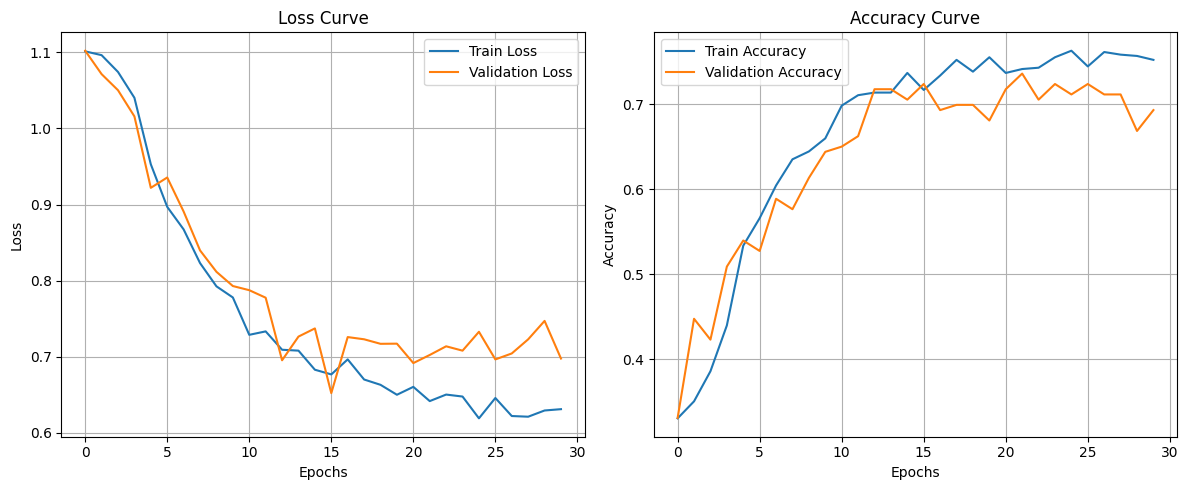

In [38]:
# -------- Loss & Accuracy Curves --------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---------- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

           0       0.64      0.88      0.74        51
           1       0.77      0.84      0.80        56
           2       0.78      0.45      0.57        56

    accuracy                           0.72       163
   macro avg       0.73      0.72      0.71       163
weighted avg       0.73      0.72      0.70       163



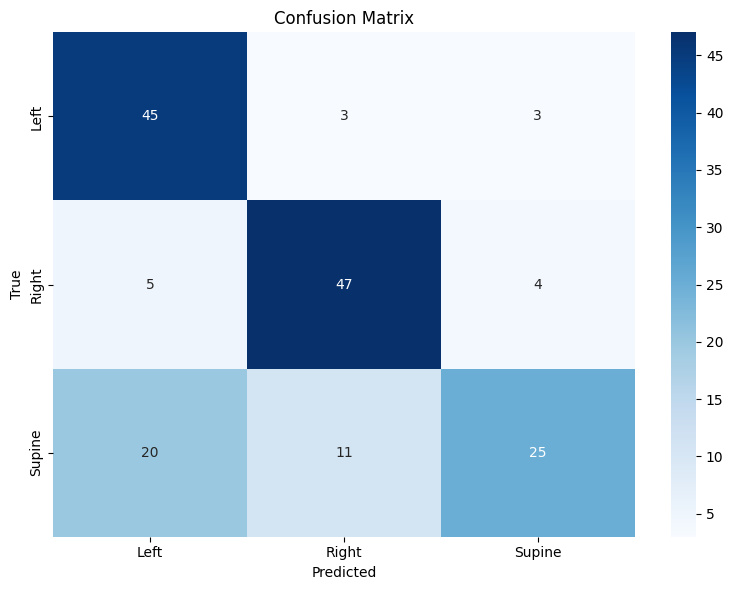

In [40]:
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("---------- CLASSIFICATION REPORT ----------")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


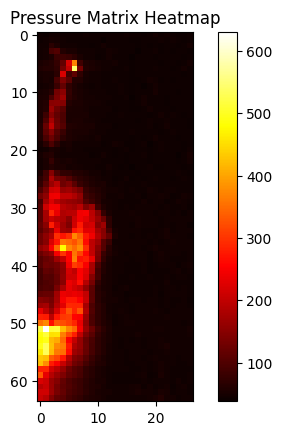

NameError: name 'scaler' is not defined

In [13]:
# Prediction function
def predict_from_file(file_path):
    if not os.path.exists(file_path):
        print("File does not exist.")
        return

    # Load and visualize pressure matrix
    matrix = np.loadtxt(file_path)
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.title("Pressure Matrix Heatmap")
    plt.colorbar()
    plt.show()

    # Preprocess: scale, flatten, reduce
    matrix_flat = matrix.flatten().reshape(1, -1)

    # Now check shape match
    if matrix_flat.shape[1] != scaler.n_features_in_:
        raise ValueError(f"Expected {scaler.n_features_in_} features, but got {matrix_flat.shape[1]}")

    matrix_scaled = scaler.transform(matrix_flat)

    # Load trained UMAP model
    umap_model = joblib.load(r"D:\QCNN\preprocess\umap3_model.pkl")
    matrix_umap = umap_model.transform(matrix_scaled)
    input_tensor = torch.tensor(matrix_umap, dtype=torch.float32)

    # Load model
    model = QCNN(11,6, num_classes=3)  # Update num_classes if needed
    model.load_state_dict(torch.load("qcnn3_model.pth", map_location=torch.device('cpu')))
    model.eval()

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # Define label mapping manually or load from file if saved
    label_mapping = {label: idx for idx, label in enumerate(sorted(labels_df['Label'].unique()))}
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    print(label_mapping)

    print(f"Predicted Posture: {reverse_label_mapping.get(pred, 'Unknown')}")

predict_from_file("D:/QCNN/experiment-ii/S1/Sponge_Mat/Matrix_Sponge_C1.txt")